In [12]:
import pandas as pd
df = pd.read_csv("..//static//csv//car_price_prediction.csv", sep=",")
df.columns

Index(['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year',
       'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags'],
      dtype='object')

определение бизнесцелей:
1. Прогнозирование цены автомобиля.
2. Оценка факторов, влияющих на цену автомобиля.

Определение целей технического проекта:
1. Построить модель машинного обучения для регрессии, которая будет прогнозировать стоимость автомобиля на основе предоставленных данных о его характеристиках.
2. Провести анализ данных для выявления ключевых факторов, влияющих на стоимость автомобиля.

преобразуем пробег в число

In [13]:
df['Mileage'] = df['Mileage'].str.replace(r'\D+', '', regex=True).astype(float)

посмотрим выбросы и усредним их:

In [14]:
numeric_columns = ['Price', 'Mileage']
for column in numeric_columns:
    if pd.api.types.is_numeric_dtype(df[column]):  # Проверяем, является ли колонка числовой
        q1 = df[column].quantile(0.25)  # Находим 1-й квартиль (Q1)
        q3 = df[column].quantile(0.75)  # Находим 3-й квартиль (Q3)
        iqr = q3 - q1  # Вычисляем межквартильный размах (IQR)

        # Определяем границы для выбросов
        lower_bound = q1 - 1.5 * iqr  # Нижняя граница
        upper_bound = q3 + 1.5 * iqr  # Верхняя граница

        # Подсчитываем количество выбросов
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_count = outliers.shape[0]

        # Устраняем выбросы: заменяем значения ниже нижней границы на саму нижнюю границу, а выше верхней — на верхнюю
        df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)

        print(f"Колонка {column}:")
        print(f"  Есть выбросы: {'Да' if outlier_count > 0 else 'Нет'}")
        print(f"  Количество выбросов: {outlier_count}")
        print(f"  Минимальное значение: {df[column].min()}")
        print(f"  Максимальное значение: {df[column].max()}")
        print(f"  1-й квартиль (Q1): {q1}")
        print(f"  3-й квартиль (Q3): {q3}\n")

Колонка Price:
  Есть выбросы: Да
  Количество выбросов: 1073
  Минимальное значение: 1.0
  Максимальное значение: 47191.0
  1-й квартиль (Q1): 5331.0
  3-й квартиль (Q3): 22075.0

Колонка Mileage:
  Есть выбросы: Да
  Количество выбросов: 640
  Минимальное значение: 0.0
  Максимальное значение: 367011.5
  1-й квартиль (Q1): 70139.0
  3-й квартиль (Q3): 188888.0



превращаем тире во чтото


In [15]:
import numpy as np
# Замена прочерков "-" в столбце Levy на NaN
df['Levy'].replace("-", np.nan, inplace=True)

# Преобразование столбца Levy в числовой формат (если он был строковым)
df['Levy'] = pd.to_numeric(df['Levy'], errors='coerce')

# Заполнение пропусков в столбце Levy медианой
df['Levy'].fillna(df['Levy'].median(), inplace=True)


C:\Users\bingo\AppData\Local\Temp\ipykernel_13744\3336777531.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Levy'].replace("-", np.nan, inplace=True)
C:\Users\bingo\AppData\Local\Temp\ipykernel_13744\3336777531.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

код конструирования полей, все номинальные превращаем в числовые


In [16]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#Пример: Создание нового признака "Age" (возраст автомобиля)
df['Age'] = 2024 - df['Prod. year']

df['Leather Interior'] = df['Leather interior'].apply(lambda x: 1 if x == 'Yes' else 0)

# Удаление ненужного столбца 'Prod. year', так как он был использован для создания 'Age'
df.drop(columns=['Prod. year'], inplace=True)
df.drop(columns=['Leather interior'], inplace=True)

# Определение категориальных признаков для преобразования
categorical_columns = ['Manufacturer', 'Engine volume', 'Doors', 'Wheel', 'Category', 'Fuel type', 'Gear box type', 'Color', 'Drive wheels']

# Инициализация OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop="first")

# Применение OneHotEncoder к выбранным категориальным признакам
encoded_values = encoder.fit_transform(df[categorical_columns])

# Получение имен новых закодированных столбцов
encoded_columns = encoder.get_feature_names_out(categorical_columns)

# Преобразование в DataFrame
encoded_values_df = pd.DataFrame(encoded_values, columns=encoded_columns)

# Объединение закодированных значений с оригинальным DataFrame, исключив исходные категориальные столбцы
df = df.drop(columns=categorical_columns)
df = pd.concat([df.reset_index(drop=True), encoded_values_df.reset_index(drop=True)], axis=1)

# Применение Label Encoding для столбца 'Model'
label_encoder = LabelEncoder()
df['Model'] = label_encoder.fit_transform(df['Model'])

print(df.head())

         ID    Price    Levy  Model   Mileage  Cylinders  Airbags  Age  \
0  45654403  13328.0  1399.0   1242  186005.0        6.0       12   14   
1  44731507  16621.0  1018.0    658  192000.0        6.0        8   13   
2  45774419   8467.0   781.0    684  200000.0        4.0        2   18   
3  45769185   3607.0   862.0    661  168966.0        4.0        0   13   
4  45809263  11726.0   446.0    684   91901.0        4.0        4   10   

   Leather Interior  Manufacturer_ALFA ROMEO  ...  Color_Orange  Color_Pink  \
0                 1                      0.0  ...           0.0         0.0   
1                 0                      0.0  ...           0.0         0.0   
2                 0                      0.0  ...           0.0         0.0   
3                 1                      0.0  ...           0.0         0.0   
4                 1                      0.0  ...           0.0         0.0   

   Color_Purple  Color_Red  Color_Silver  Color_Sky blue  Color_White  \
0      

Создадим выборки данных. разбивать будем относительно параметра цены, ведь это тот самый параметр по которому наша выборка разбивается на классы. И собственно его нам и надо будет предсказывать

In [17]:
from sklearn.model_selection import train_test_split

# Выделение признаков (X) и целевой переменной (y)
X = df.drop(columns=['Price'])  # Признаки
y = df['Price']                 # Целевая переменная (цена автомобиля)

# Разделение данных на обучающую и временную выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Разделение временной выборки на контрольную и тестовую выборки
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Проверка размеров выборок
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер контрольной выборки: {X_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (11542, 217)
Размер контрольной выборки: (3847, 217)
Размер тестовой выборки: (3848, 217)


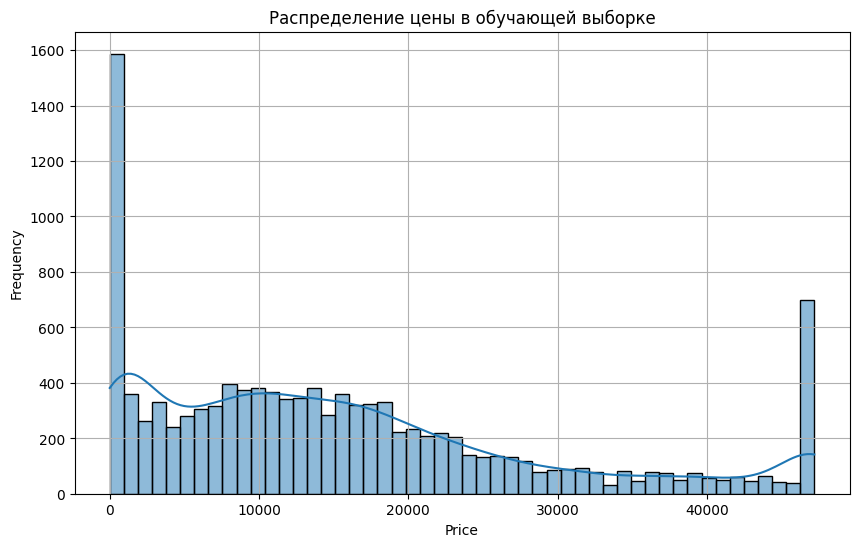

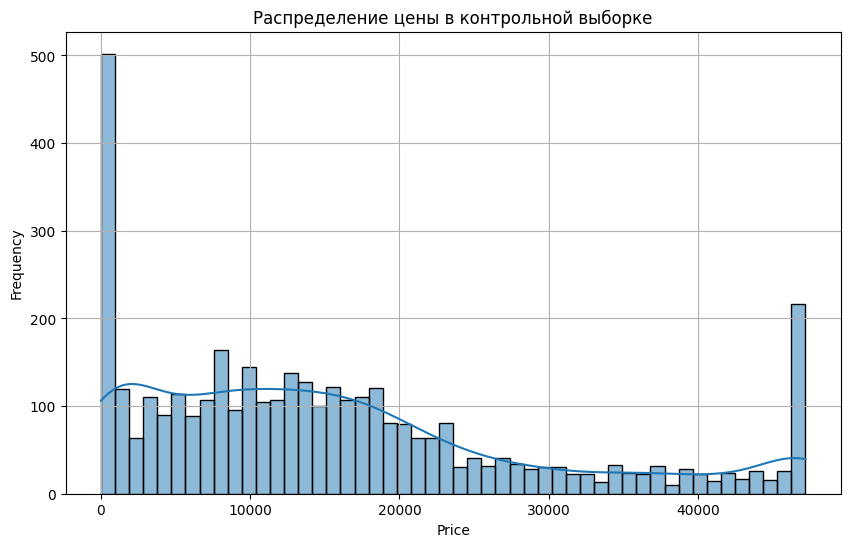

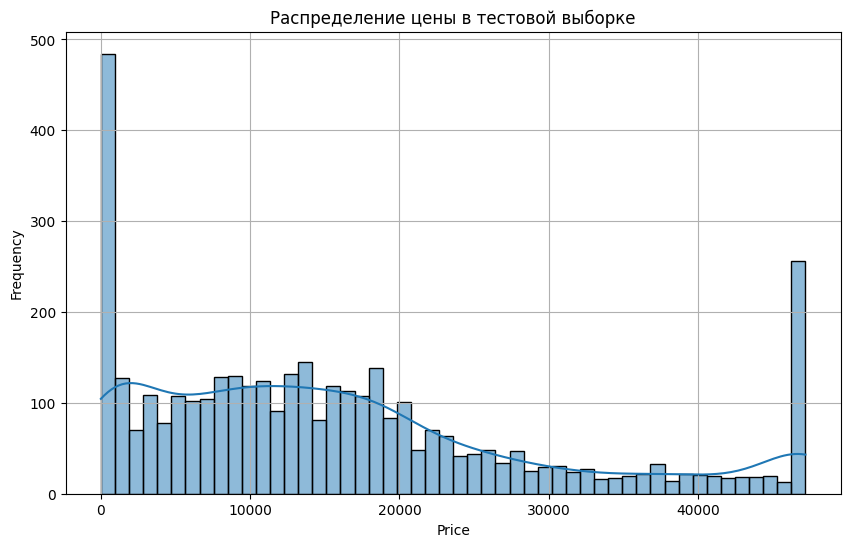

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
# Функция для оценки распределения цены
def plot_distribution(y_data, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(y_data, kde=True, bins=50)
    plt.title(title)
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Оценка распределения цены в каждой выборке
plot_distribution(y_train, "Распределение цены в обучающей выборке")
plot_distribution(y_val, "Распределение цены в контрольной выборке")
plot_distribution(y_test, "Распределение цены в тестовой выборке")


In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Предполагаем, что вы уже выделили ваши признаки X
# Применение нормировки Min-Max к всем числовым признакам
min_max_scaler = MinMaxScaler()
X_normalized = pd.DataFrame(min_max_scaler.fit_transform(X), columns=X.columns)

# Применение стандартизации к всем числовым признакам
standard_scaler = StandardScaler()
X_standardized = pd.DataFrame(standard_scaler.fit_transform(X), columns=X.columns)

# Проверка первых 5 строк после нормировки
print("Нормированные данные:")
print(X_normalized.head())

# Проверка первых 5 строк после стандартизации
print("\nСтандартизированные данные:")
print(X_standardized.head())

Нормированные данные:
         ID      Levy     Model   Mileage  Cylinders  Airbags       Age  \
0  0.993528  0.112841  0.781624  0.506810   0.333333    0.750  0.123457   
1  0.956715  0.080072  0.414097  0.523144   0.333333    0.500  0.111111   
2  0.998315  0.059689  0.430459  0.544942   0.200000    0.125  0.172840   
3  0.998107  0.066655  0.415985  0.460383   0.200000    0.000  0.111111   
4  0.999705  0.030876  0.430459  0.250404   0.200000    0.250  0.074074   

   Leather Interior  Manufacturer_ALFA ROMEO  Manufacturer_ASTON MARTIN  ...  \
0               1.0                      0.0                        0.0  ...   
1               0.0                      0.0                        0.0  ...   
2               0.0                      0.0                        0.0  ...   
3               1.0                      0.0                        0.0  ...   
4               1.0                      0.0                        0.0  ...   

   Color_Orange  Color_Pink  Color_Purple  Col

## пример использование feature tools 
попытаюсь вынести model в отдельную таблицу

In [20]:
pip install --upgrade featuretools

In [21]:
pip install --upgrade setuptools

Note: you may need to restart the kernel to use updated packages.


In [27]:
import featuretools as ft
from woodwork.logical_types import Categorical, Integer
# Создание двух таблиц: одна с моделью, другая с остальными данными
model_df = df[['ID', 'Model']].drop_duplicates().reset_index(drop=True)
other_df = df.drop(columns=['Model'])

# Создание уникального идентификатора для связи
model_df['model_id'] = model_df.index
other_df['model_id'] = other_df['ID'].map(model_df.set_index('ID')['model_id'])

es = ft.EntitySet(id="orders")
es = es.add_dataframe(
    dataframe_name="model_table",
    dataframe=model_df,
    index="model_id",  # Индекс для уникальной идентификации моделей
    logical_types={
        "Model": Categorical  # Определяем логический тип для модели
    },
)
es = es.add_dataframe(
    dataframe_name="car_features",
    dataframe=other_df,
    index="car_id",  # Индекс для уникальной идентификации автомобилей
    logical_types={
        "Price": Integer,  # Целевая переменная (цена)
        "Mileage": Integer,  # Пробег (числовой признак)
        "model_id": Integer,  # Пробег (числовой признак)
    },
)
es = es.add_relationship("model_table", "model_id", "car_features", "model_id")

feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="car_features",
    agg_primitives=["mean", "count", "mode", "any"],
    trans_primitives=["hour", "weekday"],
    max_depth=2,
)

feature_matrix

d:\МИИ\AIM-PIbd-31-Kouvshinoff-T-A\laba\Lib\site-packages\featuretools\entityset\entityset.py:1733: UserWarning: index car_id not found in dataframe, creating new integer column
  warnings.warn(
d:\МИИ\AIM-PIbd-31-Kouvshinoff-T-A\laba\Lib\site-packages\featuretools\synthesis\dfs.py:321: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  trans_primitives: ['hour', 'weekday']
  agg_primitives: ['any', 'mode']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)
d:\МИИ\AIM-PIbd-31-Kouvshinoff-T-A\laba\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x0000018799E0EB60> is currently using Se

ID  Price    Levy  Mileage  Cylinders  Airbags  Age  \
car_id                                                              
0       45654403  13328  1399.0   186005        6.0       12   14   
1       44731507  16621  1018.0   192000        6.0        8   13   
2       45774419   8467   781.0   200000        4.0        2   18   
3       45769185   3607   862.0   168966        4.0        0   13   
4       45809263  11726   446.0    91901        4.0        4   10   
...          ...    ...     ...      ...        ...      ...  ...   
19232   45798355   8467   781.0   300000        4.0        5   25   
19233   45778856  15681   831.0   161600        4.0        8   13   
19234   45804997  26108   836.0   116365        4.0        4   14   
19235   45793526   5331  1288.0    51258        4.0        4   17   
19236   45813273    470   753.0   186923        4.0       12   12   

        Leather Interior  Manufacturer_ALFA ROMEO  Manufacturer_ASTON MARTIN  \
car_id                                                                         
0                      1                      0.0                        0.0   
1                      0                      0.0                        0.0   
2                      0                      0.0                        0.0   
3                      1                      0.0                        0.0   
4                      1                      0.0                        0.0   
...                  ...                      ...                        ...   
19232                  1                      0.0                        0.0   
19233                  1                      0.0                        0.0   
19234                  1                      0.0                        0.0   
19235                  1                      0.0                        0.0   
19236                  1                      0.0                        0.0   

        ...  model_table.MEAN(car_features.Manufacturer_TOYOTA)  \
car_id  ...                                                       
0       ...                                                0.0    
1       ...                                                0.0    
2       ...                                                0.0    
3       ...                                                0.0    
4       ...                                                0.0    
...     ...                                                ...    
19232   ...                                                0.0    
19233   ...                                                0.0    
19234   ...                                                0.0    
19235   ...                                                0.0    
19236   ...                                                0.0    

        model_table.MEAN(car_features.Manufacturer_UAZ)  \
car_id                                                    
0                                                   0.0   
1                                                   0.0   
2                                                   0.0   
3                                                   0.0   
4                                                   0.0   
...                                                 ...   
19232                                               0.0   
19233                                               0.0   
19234                                               0.0   
19235                                               0.0   
19236                                               0.0   

        model_table.MEAN(car_features.Manufacturer_VAZ)  \
car_id                                                    
0                                                   0.0   
1                                                   0.0   
2                                                   0.0   
3                                                   0.0   
4                                                   0.0   
...                   